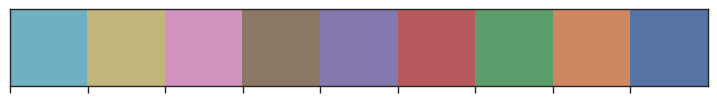

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sc
import numba
from scipy import signal


sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

colors = sns.color_palette('deep', 10, desat = 0.8)
colors = colors[::-1]
colors.pop(2)

sns.set_palette(colors)

sns.palplot(colors)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.grid.which'] = 'major'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
a = 2
b = 5.2
c = 1
d = 1

@numba.njit
def x_dot(x, y, V):
    dxdt = a*V - (b + d) * x + c/(V**2) * x**2 * y
    return dxdt

@numba.njit
def y_dot(x, y, V):
    dydt = b*x - c/(V**2) * x**2 * y
    return dydt
    
@numba.njit
def x_mark(V, a, d):
    return a*V / d

@numba.njit
def y_mark(V, a, b,  c, d):
    return V * b * d / (c * a)


In [3]:
# Euler method

@numba.njit
def euler(var_change, V, dt, t_max):
    var = var_change*V
    x = var[0]
    y = var[1]
    t = 0
    x_list = []
    y_list = []
    t_list = []
    while t < t_max:
        x_list.append(x)
        y_list.append(y)
        t_list.append(t)
        x += dt * x_dot(x, y, V)
        y += dt * y_dot(x, y, V)
        t += dt
    return x_list, y_list, t_list


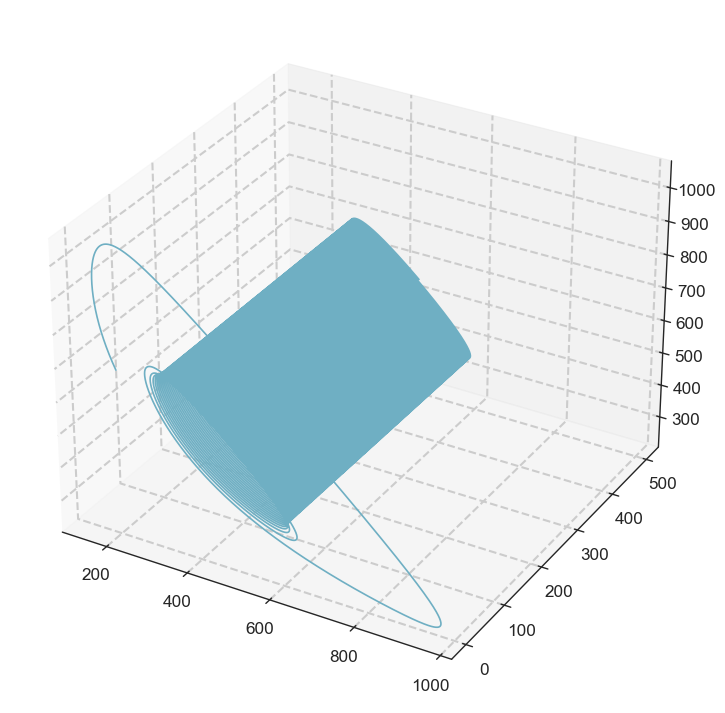

In [4]:

V = 200
var_change = np.array([1, 3.5])
dt = 0.001
t_max = 500

x_list, y_list, t_list = euler(var_change, V, dt, t_max)
x_star = x_mark(V, a, d)
y_star = y_mark(V, a, b, c, d)

# 3D plot
fig = plt.figure(figsize=(16,9), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_list, t_list, y_list)


In [5]:
# Finding peaks and mean freq of x(t) and y(t)

@numba.njit
def freq_find(list1, list2):
    coord_peaks = []
    t_peaks = []
    for i in range(1, len(list1)-1):
        if list1[i] > list1[i-1] and list1[i] > list1[i+1]:
            coord_peaks.append(list1[i])
            t_peaks.append(list2[i])

    freq = []
    for j in range(len(t_peaks)-1):
        freq.append(1/(t_peaks[j+1] - t_peaks[j]))
    
    freq_mean = np.mean(freq)
    
    return freq_mean

# find the frequency of the peaks

x_mean_freq = freq_find(x_list, t_list)
y_mean_freq = freq_find(y_list, t_list)



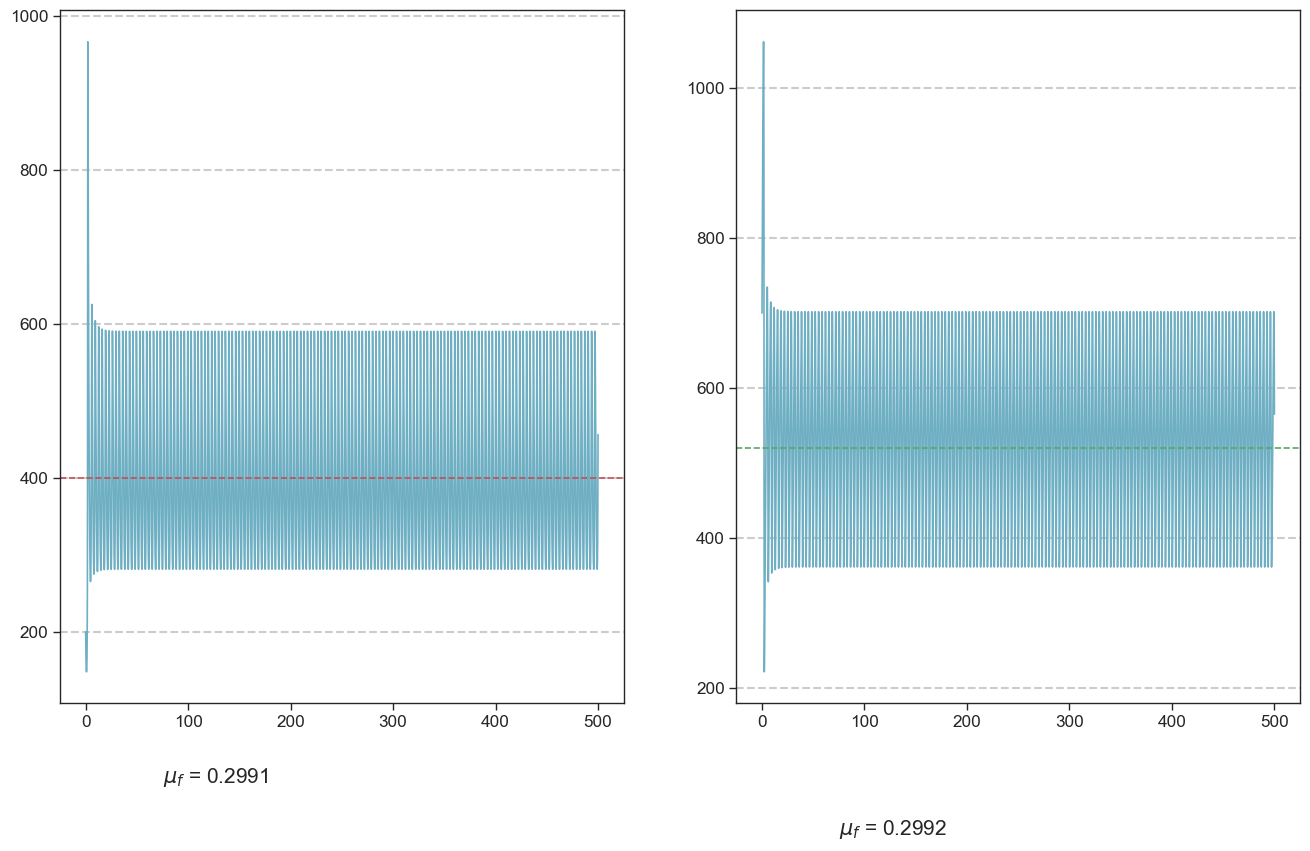

In [6]:

fig, ax = plt.subplots(1,2, figsize=(16,9), dpi=100)
ax[0].plot(t_list, x_list, label='x')
# ax[0].plot(tx_peaks, x_peaks, 'ro', label='peaks')
ax[0].axhline(x_star, color='r', linestyle='--', label='x*')
ax[0].text(75, 3.65, f'$\mu_f$ = {x_mean_freq:.4f}', fontsize=15);

ax[1].plot(t_list, y_list, label='y')
# ax[1].plot(ty_peaks, y_peaks, 'ro', label='peaks')
ax[1].axhline(y_star, color='g', linestyle='--', label='y*')

ax[1].text(75, 4.25, f'$\mu_f$ = {y_mean_freq:.4f}', fontsize=15);

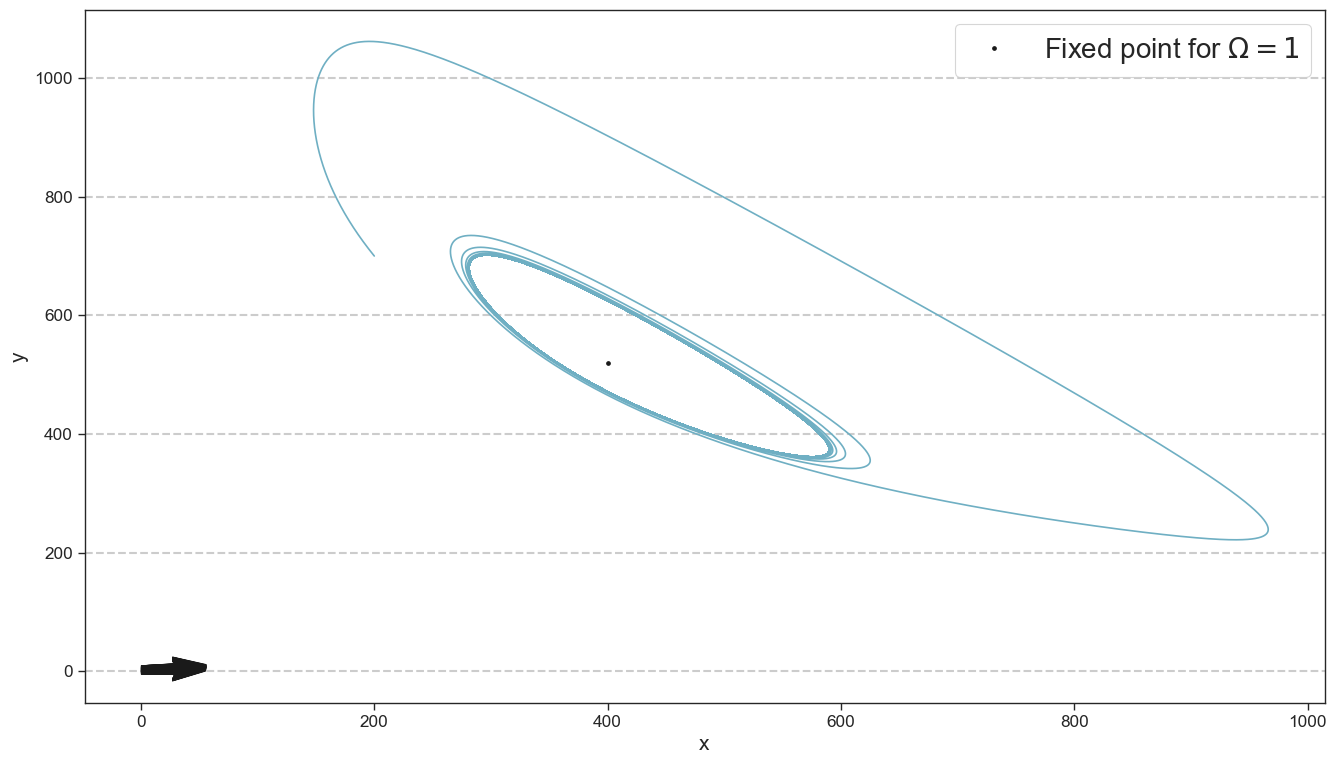

In [7]:
# 2D plot
fig = plt.figure(figsize=(16,9), dpi=100)
plt.plot(x_list, y_list)
plt.plot(x_star, y_star, 'k.', label=f'Fixed point for $\Omega = 1$')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)


# Vector field
field_size = np.arange(0, 5.5, 0.5)
X, Y = np.meshgrid(field_size, field_size)
U = x_dot(X, Y, V)
P = y_dot(X, Y, V)


plt.quiver(X, Y, U, P);


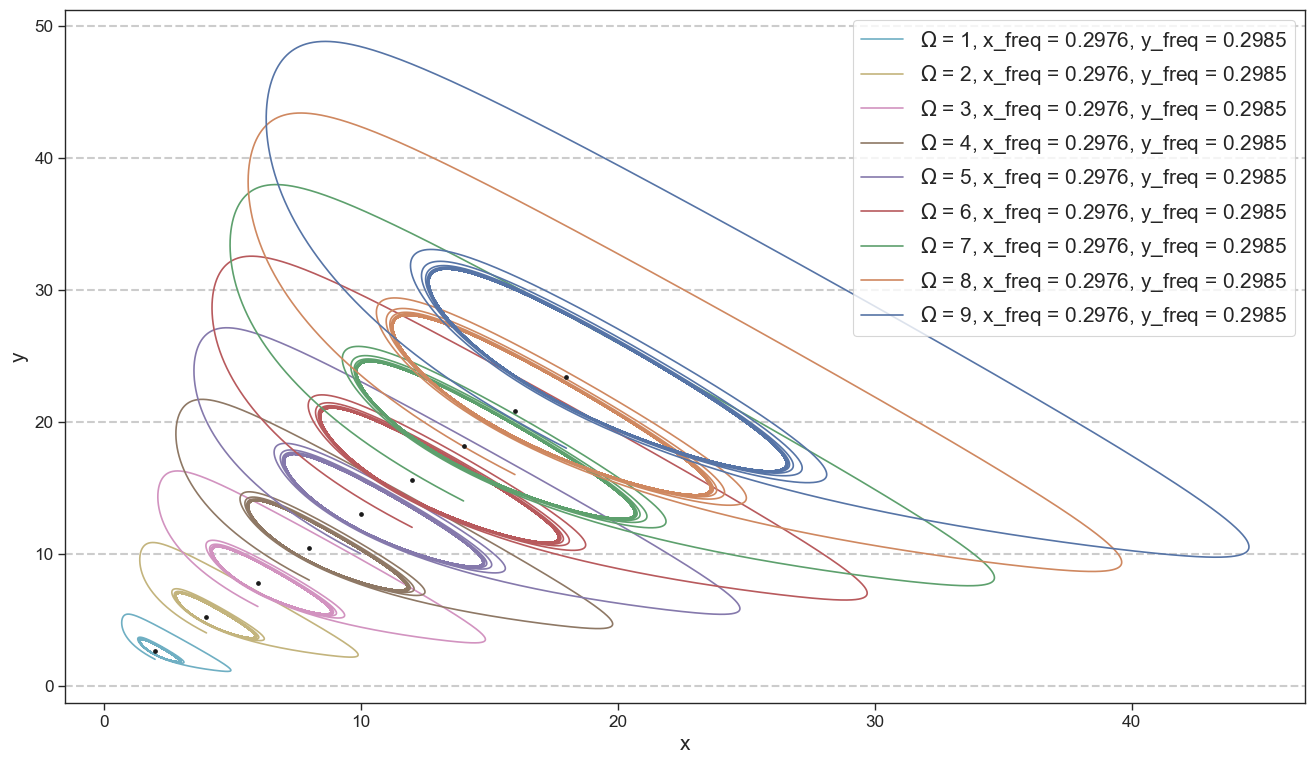

In [8]:
omega = np.arange(1, 10, 1)
var_change = np.array([2, 2])
x_mark_list = []
y_mark_list = []
x_freq_list = []
y_freq_list = []
dt_new = 0.001
t_max_new = 100

plt.figure(figsize=(16,9), dpi=100)
for i in omega:
    x_list_sim, y_list_sim, t_list_sim = euler(var_change, i, dt_new, t_max_new)
    x_mark_list.append(x_mark(i, a, d))
    y_mark_list.append(y_mark(i, a, b, c, d))
    x_freq = freq_find(x_list_sim, t_list_sim)
    y_freq = freq_find(y_list_sim, t_list_sim)
    plt.plot(x_list_sim, y_list_sim, label=f'$\Omega$ = {i}, x_freq = {x_freq:.4f}, y_freq = {y_freq:.4f}')
    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=15)
    plt.legend(fontsize=15)

plt.plot(x_mark_list, y_mark_list, 'k.', label='Stable fixed point')

____

# Adding oscillatory term $ A cos(\omega t)$

In [9]:

def x_dot(x, y, t, a, b, c, d, V, omega, A):
    dxdt = a*V - (b + d) * x + c/(V**2) * x**2 * y + A * np.cos(omega * t)
    return dxdt

def y_dot(x, y, V, b, c):
    dydt = b*x - c/(V**2) * x**2 * y
    return dydt

a = 2
b = 4.5
c = 1
d = 1
V = 100


def euler(var_change, V, omega, A, dt, t_max):
    var = var_change*V
    x = var[0]
    y = var[1]
    t = 0
    x_list = []
    y_list = []
    t_list = []
    while t < t_max:
        x_list.append(x)
        y_list.append(y)
        t_list.append(t)
        x += dt * x_dot(x, y, t, a, b, c, d, V, omega, A)
        y += dt * y_dot(x, y, V, b, c)
        t += dt
    return x_list, y_list, t_list


def amplitude_find(list1, list2, t_list, t_choise = 30):
    t_list = np.array(t_list)
    list1 = np.array(list1)
    list2 = np.array(list2)
    
    mask = np.where(t_list > t_choise)
    list1_mask = list1[mask[0]]
    list2_mask = list2[mask[0]]

    return np.max(list1_mask) - np.min(list1_mask), np.max(list2_mask) - np.min(list2_mask)



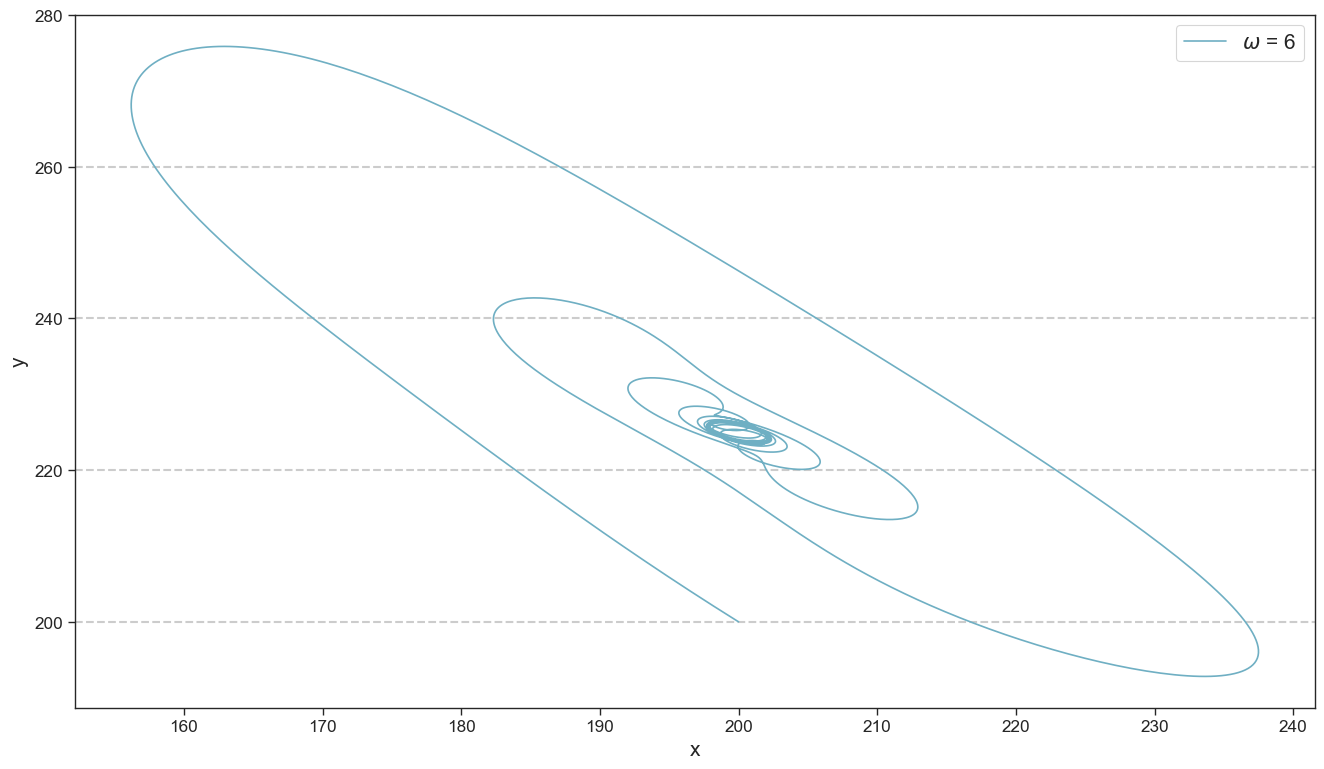

In [10]:
# run euler simulaiton with new x_dot and y_dot functions

omega = np.array([6])
var_change = np.array([2, 2])
A = 10
t_max = 100
dt = 0.01

fig, ax = plt.subplots(figsize=(16,9), dpi=100)

for i in omega:
    x_list, y_list, t_list = euler(var_change, V, i, A, dt, t_max)
    ax.plot(x_list, y_list, label=f'$\omega$ = {i}')

ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15)
ax.legend(fontsize=15)




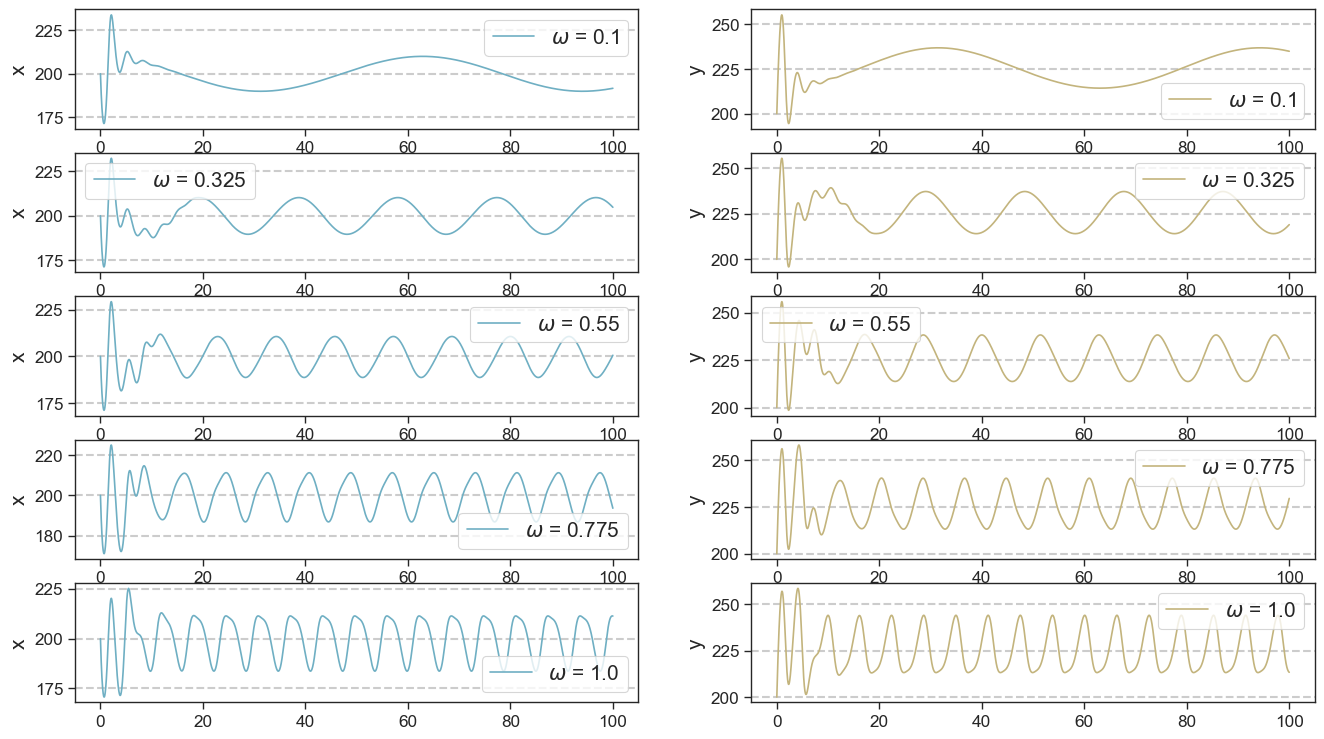

In [11]:
# plot x(t) and y(t) for different omega values

omega = np.linspace(0.1, 1, 5)
var_change = np.array([2, 2])
A = 10
t_max = 100
dt = 0.01

fig_rows = len(omega)
fig, ax = plt.subplots(fig_rows, 2, figsize=(16,9), dpi=100)


amp_x = []
amp_y = []

for i, j in enumerate(omega):
    x_list, y_list, t_list = euler(var_change, V, j, A, dt, t_max)
    

    ax[i, 0].plot(t_list, x_list, label=f'$\omega$ = {j}')
    ax[i, 1].plot(t_list, y_list, label=f'$\omega$ = {j}', color = colors[1])
    ax[i, 0].set_ylabel('x', fontsize=15)
    ax[i, 1].set_ylabel('y', fontsize=15)
    ax[i, 0].legend(fontsize=15)
    ax[i, 1].legend(fontsize=15)



### For a large number of $\omega$ 

In [12]:
omega_list = np.linspace(0.1, 5, 1000)    
var_change = np.array([2, 2])
A = 10
t_max = 100
dt = 0.01

amp_x = []
amp_y = []

for i in omega_list:
    x_list, y_list, t_list = euler(var_change, V, i, A, dt, t_max)
    x_max, y_max = amplitude_find(x_list, y_list, t_list, t_choise=30)
    amp_x.append(x_max)
    amp_y.append(y_max)


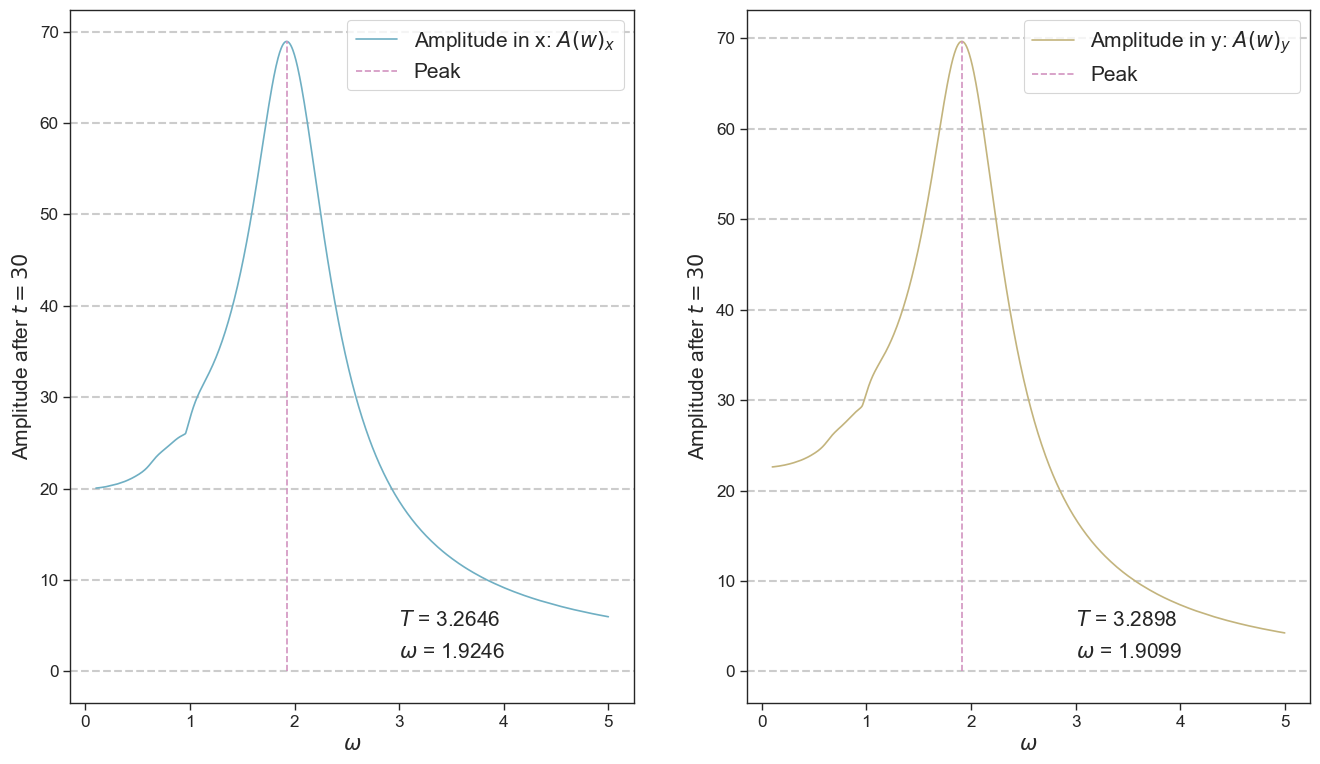

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16,9), dpi=100)
ax = ax.flatten()

# find peak

x_peak = np.max(amp_x)
y_peak = np.max(amp_y)
omega_x_peak = omega_list[np.argmax(amp_x)]
omega_y_peak = omega_list[np.argmax(amp_y)]
T_x = 2*np.pi/omega_x_peak
T_y = 2*np.pi/omega_y_peak

ax[0].plot(omega_list, amp_x, label=r'Amplitude in x: $A(w)_x$')
ax[0].set_xlabel('$\omega$', fontsize=15)
ax[0].set_ylabel('Amplitude after $t=30$', fontsize=15)
ax[0].vlines(omega_x_peak, 0, x_peak, color= colors[2], linestyle='--', label='Peak')
ax[0].text(3, 1.5, f'$\omega$ = {omega_x_peak:.4f}', fontsize=15);
ax[0].text(3, 5, f'$T$ = {T_x:.4f}', fontsize=15);
ax[0].legend(fontsize=15)

ax[1].plot(omega_list, amp_y, label=r'Amplitude in y: $A(w)_y$', color = colors[1])
ax[1].set_xlabel('$\omega$', fontsize=15)
ax[1].vlines(omega_y_peak, 0, y_peak, color=colors[2], linestyle='--', label='Peak')
ax[1].set_ylabel('Amplitude after $t=30$', fontsize=15)
ax[1].text(3, 1.5, f'$\omega$ = {omega_y_peak:.4f}', fontsize=15);
ax[1].text(3, 5, f'$T$ = {T_y:.4f}', fontsize=15);
ax[1].legend(fontsize=15)


____

# Gillespie algorithm

In [23]:
@numba.njit
def gillespie(x, y, t_max, b_place=b, V=100):

    t = 0
    click = 1
    t_list = [0]
    x_list = [x]
    y_list = [y]

    a = 2 * V
    c = 1/V**2
    d = 1
    
    
    while t < t_max:
        # rates
        x_spawn = a
        x_to_y = b_place * x
        y_to_x = c * x * (x-1) * y
        x_despawn = d * x
        
        rates = np.array([x_spawn, x_to_y, y_to_x, x_despawn])

        r_sum = np.cumsum(rates)
        R = np.sum(rates)
        u = np.random.uniform(0, R)
        dt = -np.log(np.random.uniform())/R


        mask = r_sum > u
        index = np.where(mask == True)[0][0]

        if index == 0:
            x += 1

        elif index == 1:
            x -= 1
            y += 1

        elif index == 2:
            y -= 1
            x += 1

        elif index == 3:
            x -= 1
        
        t += dt
        ts = 0.1
        if t > ts*click:
            t_list.append(t)
            x_list.append(x)
            y_list.append(y)
            click += 1

        #t_list.append(t)
        #x_list.append(x)
        #y_list.append(y)

    return t_list, x_list, y_list



In [118]:
# Gillespie simulation initialization
vol = 100
x = 100
y = 100
t_max = 100

a = 2
b = 5.2
c = 1
d = 1

t_list, x_sim, y_sim = gillespie(x, y, t_max, b_place=b, V=vol)
x_star = x_mark(vol, a, d)
y_star = y_mark(vol, a, b, c, d)


[]


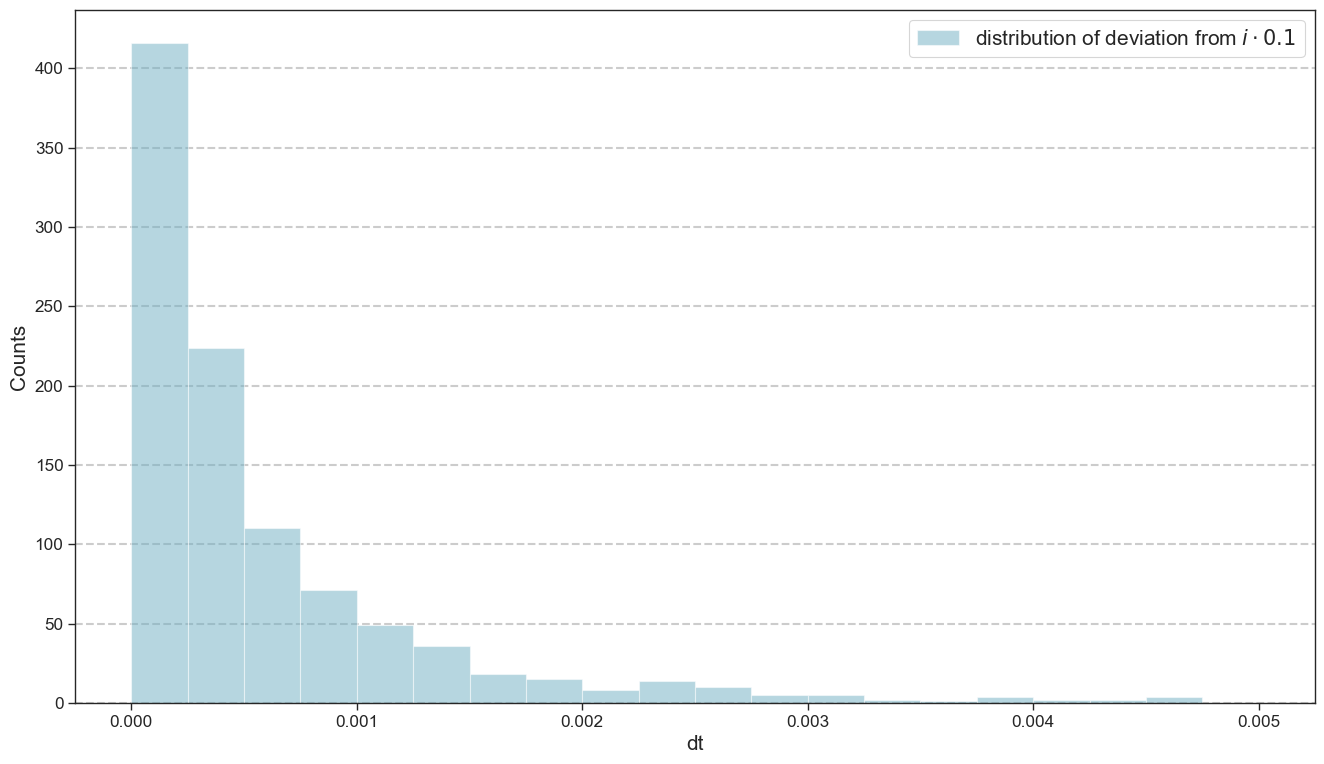

In [119]:
# Checking that the time steps are correct

n = np.arange(0, t_list[-1], 0.1)

dt_list = t_list - n
plt.hist(dt_list, bins=20, range=(0, 0.005), alpha=0.5, label=r'distribution of deviation from $i \cdot 0.1$');
plt.xlabel('dt', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.legend(fontsize=15)

over = np.where(dt_list > 0.1)
print(over[0])

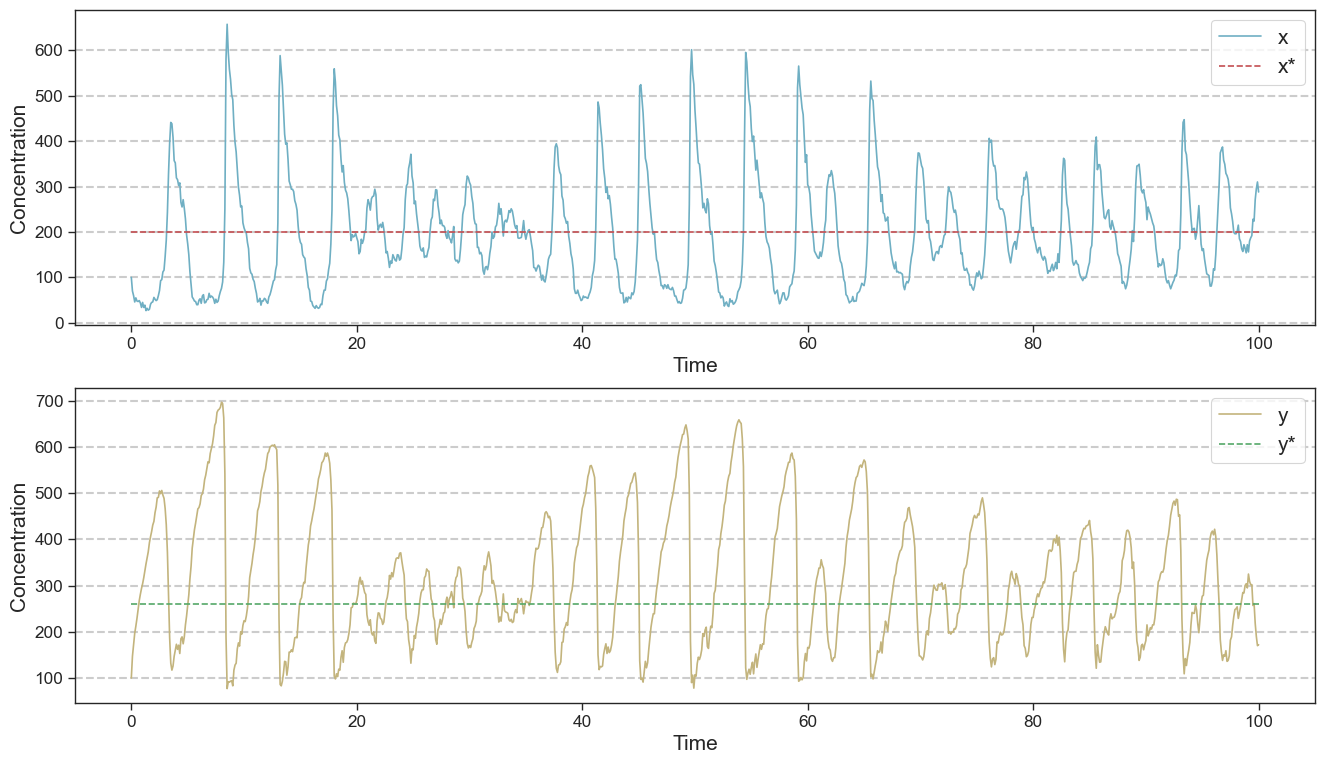

In [120]:
# Plotting gillespie simulation

fig, ax = plt.subplots(2, 1, figsize=(16,9), dpi=100)
ax[0].plot(t_list, x_sim, label='x', color=colors[0])
ax[0].hlines(x_star, 0, max_step, color='r', linestyle='--', label='x*')

ax[1].plot(t_list, y_sim, label='y', color=colors[1])
ax[1].hlines(y_star, 0, max_step, color='g', linestyle='--', label='y*')


for i in range(len(ax)):
    ax[i].set_xlabel('Time', fontsize=15)
    ax[i].set_ylabel('Concentration', fontsize=15)
    ax[i].legend(fontsize=15)



In [161]:
### High pass filter

# Define the cutoff frequency (in Hz)
cutoff_frequency = 0.04  # Cutoff frequency for high-pass filter
sampling_rate = 0.1 #np.mean(dt_list+0.1)

# Design the filter
nyquist = 0.5 * sampling_rate  # Nyquist frequency
normal_cutoff = cutoff_frequency / nyquist  # Normalize the cutoff frequency

b, a = signal.butter(4, normal_cutoff, btype='high', analog=False)  # 4th order Butterworth filter



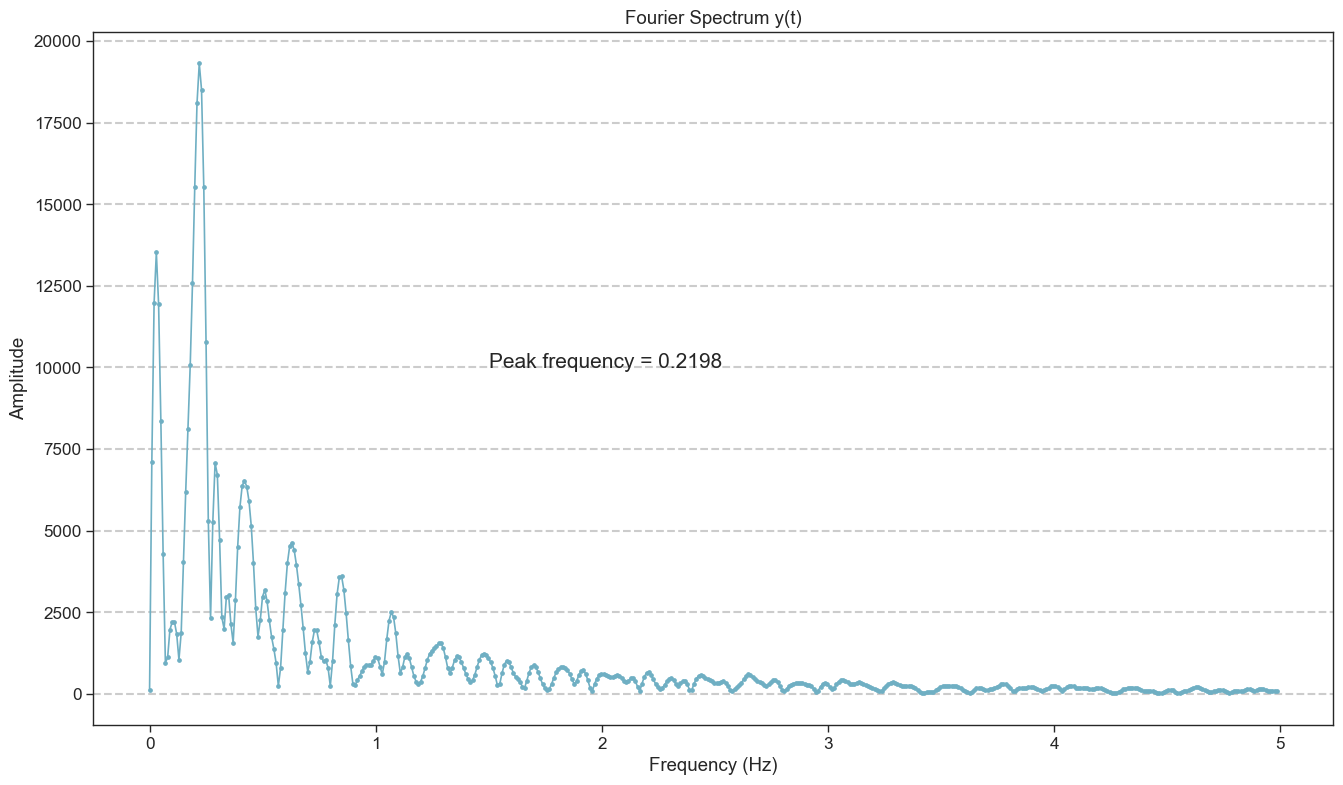

In [163]:
# Making a Fourier spectrum of x(t) and y(t) using FFT

x_fft = np.fft.fft(x_sim)
y_fft = np.fft.fft(y_sim)

# Aply HP filter
x_hpf = signal.filtfilt(b, a, x_fft)
y_hpf = signal.filtfilt(b, a, y_fft)


# Compute the amplitude spectrum
amplitude_spectrum = np.abs(y_hpf)
frequencies = np.fft.fftfreq(len(y_sim), sampling_rate)
freq_slice = frequencies[0:len(frequencies)//2]
amp_slice = amplitude_spectrum[0:len(amplitude_spectrum)//2]

# Find peak frequency
peak_freq = freq_slice[np.argmax(amp_slice)]


# Plot the amplitude spectrum
plt.figure(dpi=100)
plt.plot(freq_slice, amp_slice, marker='.', ls='-')
plt.text(1.5, 10000, f'Peak frequency = {peak_freq:.4f}', fontsize=15)
plt.title('Fourier Spectrum y(t)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

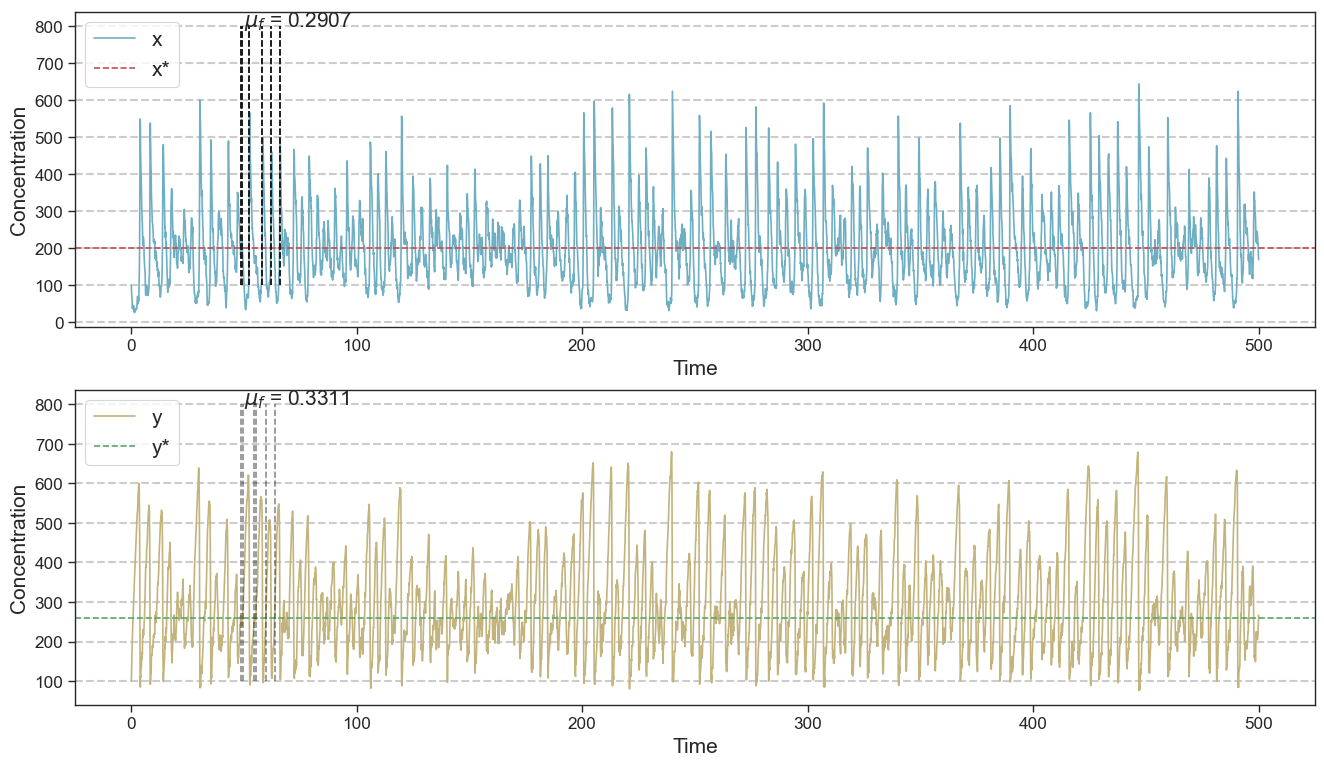

In [117]:
### Estimating frequency of x(t) and y(t)

# Finding the estimated crossing points with x* and y*
tx_est = []
ty_est = []
x_est = []
y = []

for i in range(len(t_list)):
    if x_sim[i-1] < x_star and x_sim[i] > x_star:
        tx_est.append(t_list[i])  
        x_est.append(x_sim[i])

    if y_sim[i-1] < y_star and y_sim[i] > y_star:
        ty_est.append(t_list[i])  
        y.append(y_sim[i])      

# Determining the estimated frequencies from sliced data

Nx_start = 17
Nx_end = 23

x_slice = x_est[Nx_start:Nx_end]
tx_slice = tx_est[Nx_start:Nx_end]

y_slice = y[Nx_start:Nx_end]
ty_slice = ty_est[Nx_start:Nx_end]

x_freq_est = 1/(np.mean(np.diff(tx_slice)))
y_freq_est = 1/(np.mean(np.diff(ty_slice)))

### Plotting the estimated frequencies     
fig, ax = plt.subplots(2,1, dpi=100)
ax[0].plot(t_list, x_sim, label='x', color=colors[0])
ax[0].axhline(x_star, color='r', linestyle='--', label='x*')

ax[1].plot(t_list, y_sim, label='y', color=colors[1])
ax[1].axhline(y_star, color='g', linestyle='--', label='y*')

for i in range(len(ax)):
    ax[i].set_xlabel('Time', fontsize=15)
    ax[i].set_ylabel('Concentration', fontsize=15)
    ax[i].legend(fontsize=15, loc='upper left')

for j in range(len(tx_slice)):
    ax[0].vlines(tx_slice, 100, 800, color='k', linestyle='--', label='cross with x*', alpha=0.5)

for k in range(len(ty_slice)):
    ax[1].vlines(ty_slice[k], 100, 800, color='k', linestyle='--', label='cross with y*', alpha=0.5)

ax[0].text(50, 800, f'$\mu_f$ = {x_freq_est:.4f}', fontsize=15);
ax[1].text(50, 800, f'$\mu_f$ = {y_freq_est:.4f}', fontsize=15);


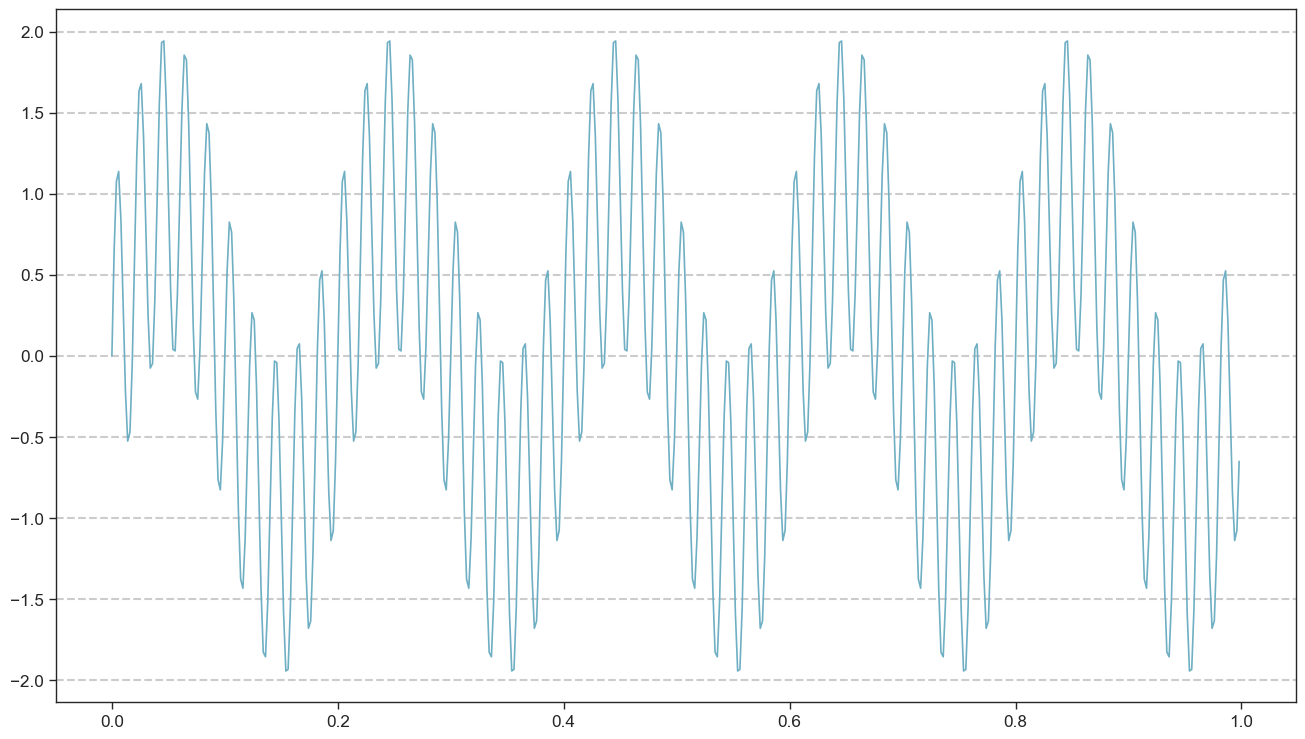

In [124]:
# Example data: Create a signal with low and high-frequency components
fs = 500  # Sampling frequency (Hz)
t = np.linspace(0, 1, fs, endpoint=False)  # 1 second of data
low_freq = np.sin(2 * np.pi * 5 * t)  # Low-frequency component (5 Hz)
high_freq = np.sin(2 * np.pi * 50 * t)  # High-frequency component (50 Hz)
x_t = low_freq + high_freq  # Combined signal

plt.plot(t,x_t)

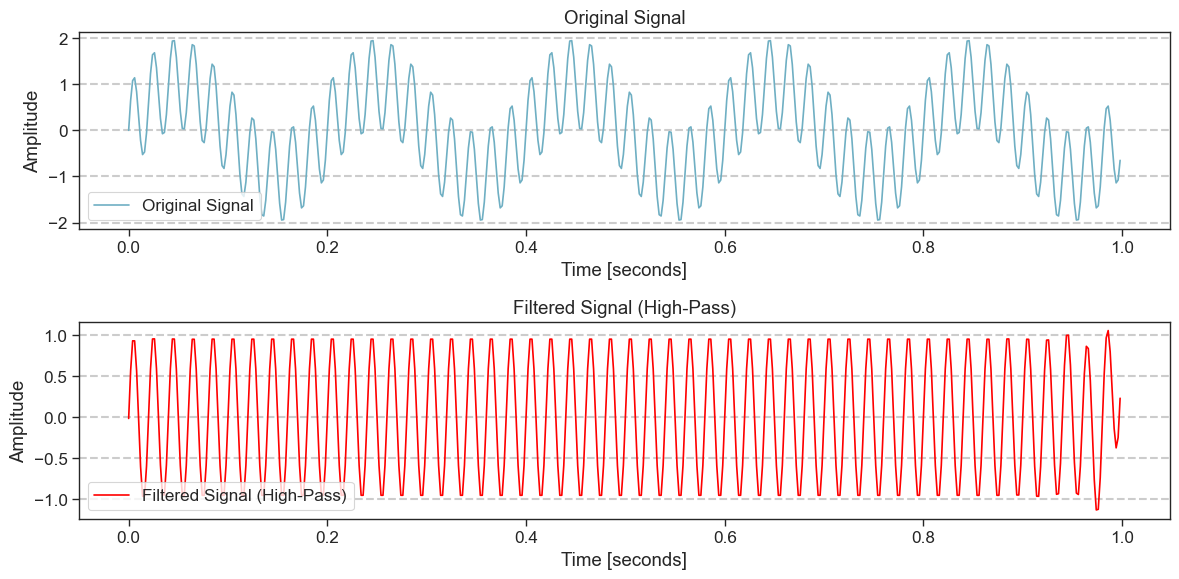

In [126]:
# Apply the high-pass filter to the data
filtered_x_t = signal.filtfilt(b, a, x_t)

# Plot the original and filtered signals
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, x_t, label='Original Signal')
plt.title('Original Signal')
plt.xlabel('Time [seconds]')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, filtered_x_t, label='Filtered Signal (High-Pass)', color='red')
plt.title('Filtered Signal (High-Pass)')
plt.xlabel('Time [seconds]')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()
